# Access BDC cubes

### install EOCubes

##### (uncomment the line if you need to install the package)

In [1]:
#pip install --user git+https://github.com/brazil-data-cube/EOCubes@master --upgrade --no-cache-dir

### Import EOCubes

In [2]:
from bdc_eocubes.business import Business as eocubes

### List all existing cubes

In [3]:
cubes = eocubes.list_cubes()
cubes

{'S1016d:MEDIAN': 'localhost:5051/describe_cube?name=S1016d:MEDIAN',
 'S1016d:STACK': 'localhost:5051/describe_cube?name=S1016d:STACK',
 'HLS_S30_MGRS_16d:MEDIAN': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:MEDIAN',
 'HLS_S30_MGRS_16d:STACK': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:STACK',
 'C6416d:MEDIAN': 'localhost:5051/describe_cube?name=C6416d:MEDIAN',
 'C6416d:STACK': 'localhost:5051/describe_cube?name=C6416d:STACK',
 'S10m:MEDIAN': 'localhost:5051/describe_cube?name=S10m:MEDIAN',
 'S10m:STACK': 'localhost:5051/describe_cube?name=S10m:STACK'}

### Get cube description

In [4]:
cube_s10 = eocubes.describe_cube('S10m:STACK')
cube_s10

{'name': 'S10m',
 'description': 'S10m datacube with products from S2SR(Sattelite/Sensor) with coastal,blue,green,red,redge1,redge2,redge3,nir,bnir,swir1,swir2,ndvi,evi,quality bands.',
 'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
 'bbox': ['-20.9079', '-67.1244', '-43.1917', '-3.54103'],
 'bands': ['coastal',
  'blue',
  'green',
  'red',
  'redge1',
  'redge2',
  'redge3',
  'nir',
  'bnir',
  'swir1',
  'swir2',
  'ndvi',
  'evi',
  'quality'],
 'tiles': ['076095', '078094', '085089', '089098', '090106']}

### Get cube

In [5]:
my_cube = eocubes.get_cube('S10m:STACK', bbox= '-46.62597656250001,-13.19716452328198,-45.03570556640626,-12.297068292853805')
my_cube

{'2018-09-01/2019-08-01': {'timeline': ['2018-09-01T00:00:00',
   '2019-08-01T00:00:00',
   '2018-11-01T00:00:00',
   '2019-04-01T00:00:00',
   '2019-02-01T00:00:00',
   '2019-05-01T00:00:00',
   '2019-06-01T00:00:00',
   '2018-12-01T00:00:00',
   '2018-10-01T00:00:00',
   '2019-01-01T00:00:00',
   '2019-03-01T00:00:00',
   '2019-07-01T00:00:00'],
  'tiles': {'089098': {'bands': {'coastal': ['http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-08-01-2019-08-31/S10m_089098_2019-08-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-11-01-2018-11-30/S10m_089098_2018-11-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-04-01-2019-04-30/S10m_089098_2019-04-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089

### Print all available Bands for this cube

In [6]:
bands = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands'].keys()
print( bands )

dict_keys(['coastal', 'blue', 'green', 'red', 'redge1', 'redge2', 'redge3', 'nir', 'bnir', 'swir1', 'swir2', 'ndvi', 'evi'])


### Given the nir band, print all available Bands for this cube

In [7]:
links_nir = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands']['nir']
links_nir

['http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-08-01-2019-08-31/S10m_089098_2019-08-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-11-01-2018-11-30/S10m_089098_2018-11-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-04-01-2019-04-30/S10m_089098_2019-04-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-02-01-2019-02-28/S10m_089098_2019-02-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-05-01-2019-05-31/S10m_089098_2019-05-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-06-01-2019-06-30/S10m_089098_2019-06-01_nir_STACK.tif',
 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-12-01-2018-12-31/S10m_089098_2018-12-01_

### Print first image link

In [8]:
filename_nir = links_nir[0]
filename_nir

'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_nir_STACK.tif'

### Imports

In [9]:
#### Import Libs ####
#import numpy
import rasterio

from math import floor, ceil
from matplotlib import pyplot as plt
from pyproj import Proj
from rasterio.warp import transform
from rasterio.windows import Window

### Function to crop dataset with longitude and latitude 

In [10]:
def longlat2window(lon, lat, dataset):
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
    p = Proj(dataset.crs)
    t = dataset.transform
    xmin, ymin = p(lon[0], lat[0])
    xmax, ymax = p(lon[1], lat[1])
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return Window.from_slices(rows=(floor(row_max), ceil(row_min)),
                              cols=(floor(col_min), ceil(col_max)))

### Load image using Row Col

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 15737, 'height': 11723, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",10],PARAMETER["standard_parallel_2",-40],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",-50],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(10.0, 0.0, 332692.0,
       0.0, -10.0, -1473850.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


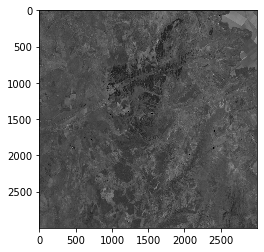

In [11]:
with rasterio.open(filename_nir) as dataset:
    print(dataset.profile)
    #img = dataset.read(1) ### open entire scene is heavy
    
    img = dataset.read(1, window=Window(0, 0, 3000, 3000)) ### Window(col_off, row_off, width, height)
    
    plt.imshow(img, cmap='gray')
    plt.show()

### Load image using Bounding box 

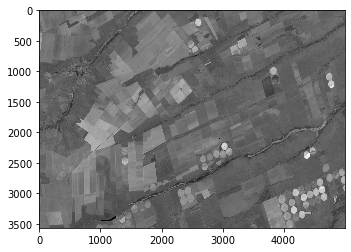

In [12]:
### CREATING BBOX ###
w = -45.90
n = -12.6
e = -45.40
s = -12.90

bbox = ( (w,e), (s,n) )

with rasterio.open(filename_nir) as dataset:
    img = dataset.read(1, window = longlat2window(bbox[0], bbox[1], dataset)) ### Window(col_off, row_off, width, height)

    plt.imshow(img, cmap='gray')
    plt.show()

### select a few bands

In [13]:
my_bands = ('red', 'nir')
my_bands

('red', 'nir')

### Import Xarray, pandas and re libs

In [14]:
import xarray
import pandas
import re

### Load entire image as Xarray

In [15]:
nir = xarray.open_rasterio(filename_nir)
nir.variable.data

array([[[2528, 2573, 2628, ..., 2172, 2196, 2228],
        [2512, 2551, 2624, ..., 2210, 2248, 2280],
        [2513, 2533, 2591, ..., 2137, 2208, 2263],
        ...,
        [2474, 2536, 2532, ..., 2326, 2365, 2402],
        [2467, 2536, 2560, ..., 2328, 2359, 2386],
        [2459, 2533, 2585, ..., 2329, 2351, 2373]]], dtype=uint16)

### Functions to load cubes as xarray dataset

In [16]:
def file_to_da(filename, bbox):
    with rasterio.open(filename) as dataset:
        img = dataset.read(1, window = longlat2window(bbox[0], bbox[1], dataset)) 
    da = xarray.DataArray(img)
    #da = xarray.open_rasterio(img)
    match = re.findall(r'\d{4}-\d{2}-\d{2}', filename)[-1]
    pandas.to_datetime(match)
    da.coords['time'] = match

    return da


def img2xarray(cube, band, bbox):
    links = cube[band]
    links.sort()
    dataset = xarray.Dataset()
    #load bands to xarray dataset
    list_of_data_arrays=[file_to_da(link, bbox) for link in links]
    dataset[band] = xarray.concat(list_of_data_arrays, dim='time')
        
    return dataset


def cube2xarray(cube_info,list_bands,bbox):   
    xray_dataset = [img2xarray(cube_info,band, bbox) for band in list_bands]
    cube_dataset = xarray.merge(xray_dataset)

    return cube_dataset

### Set a new Bounding box, select a few bands and load all to Xarray Dataset

In [17]:
w = -45.9
n = -12.65
e = -45.85
s = -12.7
bbox = ( (w,e), (s,n) )
my_bands = ( 'red', 'nir' )

cubeset = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands']

bdc_xray = cube2xarray(cubeset,my_bands,bbox)

### Calculating NDVI

In [18]:
bdc_xray['ndvi'] = (bdc_xray['red'] - bdc_xray['nir']) / (bdc_xray['red'] + bdc_xray['nir'])

### Plot

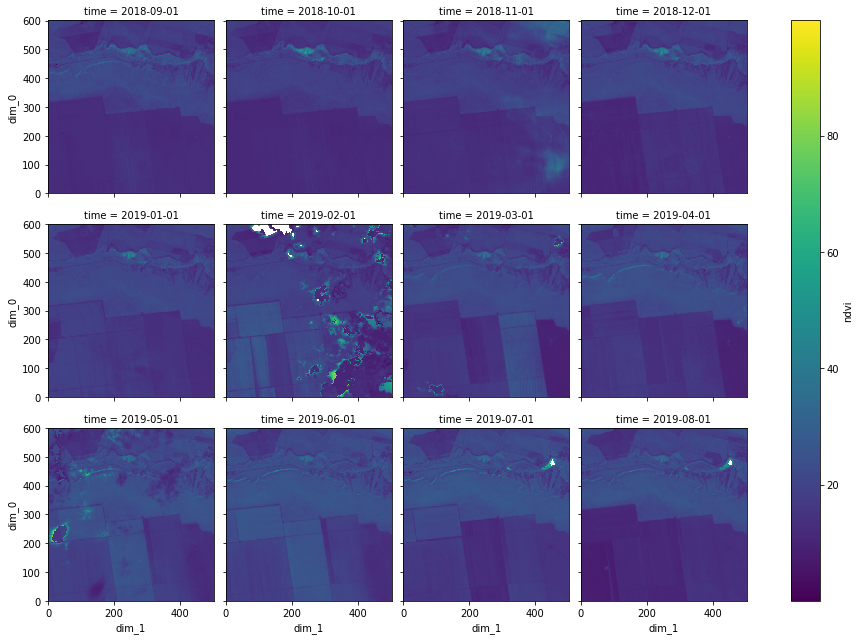

In [19]:
bdc_xray.ndvi.plot(col='time',cmap='viridis',col_wrap=4)

### LEAFLET

In [20]:
from ipyleaflet import Map, WMSLayer, basemaps, basemap_to_tiles

In [21]:
m = Map(center=[-12.75, -45.65], zoom=10)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [22]:
bands = "bands=red,green,blue" #&
#color_formula = "color_formula=Gamma RGB 5.5 Saturation 2 Sigmoidal RGB 10 0.5"
color_formula = "color_formula=Gamma RGB 5.5 Saturation 2 Sigmoidal RGB 10 0.5"
schema = color_formula

In [23]:
base = "http://brazildatacube.dpi.inpe.br/tiler/tms"

#cubename = "C6416d"
#sceneid = "C6416d_089098_2019-04-23_STACK"

cubename = "S10m"
sceneid = "S10m_089098_2018-09-01_STACK"

bdc_tms_url = "{}/{}/{}/{}/{}/{}.png?{}".format(base, cubename, sceneid, "{z}", "{x}", "{y}", schema)
print(bdc_tms_url)

http://brazildatacube.dpi.inpe.br/tiler/tms/S10m/S10m_089098_2018-09-01_STACK/{z}/{x}/{y}.png?color_formula=Gamma RGB 5.5 Saturation 2 Sigmoidal RGB 10 0.5


In [24]:
cube_layer = basemap_to_tiles({'url':bdc_tms_url,'attribution':"brazil data cube"})
m.add_layer(cube_layer)
print(cube_layer)

TileLayer(attribution='brazil data cube', max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms'], url='http://brazildatacube.dpi.inpe.br/tiler/tms/S10m/S10m_089098_2018-09-01_STACK/{z}/{x}/{y}.png?color_formula=Gamma RGB 5.5 Saturation 2 Sigmoidal RGB 10 0.5')


In [25]:
#center coordinates resulting in a bit off-center
m.zoom = 8
m.center=[-12.6, -46] 

In [27]:
m.bounds

((-13.667338259654947, -48.55957031250001),
 (-11.5230875068685, -43.43444824218751))